In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    output = torch.tanh(self.input_layer(x))
    for layer in self.hidden_layers:
      output = layer(output)

    f = self.output_layer(output)

    f_prime = torch.autograd.grad(f, x, torch.ones_like(f),create_graph=True)[0]
    f_double_prime = torch.autograd.grad(f_prime, x, torch.ones_like(f),create_graph=True)[0]
    f_triple_prime = torch.autograd.grad(f_double_prime, x, torch.ones_like(f),create_graph=True)[0]

    return f, f_prime, f_double_prime, f_triple_prime

In [ ]:
## Defining the PDE
def equation_1(f, x):
    f_x = torch.autograd.grad(f, x, torch.ones_like(f), create_graph=True)[0]
    f_xx = torch.autograd.grad(f_x, x, torch.ones_like(f), create_graph=True)[0]
    f_xxx = torch.autograd.grad(f_xx, x, torch.ones_like(f), create_graph=True)[0]
    return 0.5*f*f_xx + f_xxx

In [ ]:
## PDE training data
x1 = torch.linspace(0, 5, 201).view(-1, 1)
x1 = x1.view(-1)
x_train1 = x1.reshape(201, 1).requires_grad_(True)

In [ ]:
def boundary_conditions_loss1(f, f_prime, x):
    # Boundary condition at eta=0: f'(0) = 0
    loss_bc_0 = torch.mean((f_prime[0])**2) + torch.mean((f[0])**2)
    # Boundary condition at eta=inf: f'(inf) = 1
    loss_bc_inf = torch.mean((f_prime[-1] - 1)**2)
    return loss_bc_0 + loss_bc_inf

In [ ]:
## Initialization of PINN
torch.manual_seed(69)
pinn = PINN(1,40,1,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0005)

In [ ]:
## Training Loop
epochs = 70000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  f, f_prime, f_double_prime, f_triple_prime = pinn(x_train1)
  pde_loss = equation_1(f, x_train1).pow(2).mean()

  boundary_condition_losss = boundary_conditions_loss1(f, f_prime, x_train1)

  p1 = 1
  total_loss = 1.5*pde_loss + p1*boundary_condition_losss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 1000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_losss.item()}")

Epoch 0/70000, Total Loss: 1.0083602666854858, pde Loss: 1.733159109562621e-07, Boundary Loss: 1.0083600282669067
Epoch 1000/70000, Total Loss: 3.419827044126578e-05, pde Loss: 2.2636970243183896e-05, Boundary Loss: 2.428162702017289e-07
Epoch 2000/70000, Total Loss: 1.180406707135262e-05, pde Loss: 7.854577233956661e-06, Boundary Loss: 2.2202115701475122e-08
Epoch 3000/70000, Total Loss: 0.0021397785749286413, pde Loss: 4.0951912524178624e-05, Boundary Loss: 0.0020783506333827972
Epoch 4000/70000, Total Loss: 4.760624506161548e-06, pde Loss: 3.1636118364986032e-06, Boundary Loss: 1.520657377795942e-08
Epoch 5000/70000, Total Loss: 4.35499387094751e-05, pde Loss: 1.6853296983754262e-05, Boundary Loss: 1.8269993233843707e-05
Epoch 6000/70000, Total Loss: 4.63065407529939e-06, pde Loss: 3.07497066387441e-06, Boundary Loss: 1.8198045736994573e-08
Epoch 7000/70000, Total Loss: 2.5841181923169643e-06, pde Loss: 1.7214192666870076e-06, Boundary Loss: 1.989322928608317e-09
Epoch 8000/70000, T

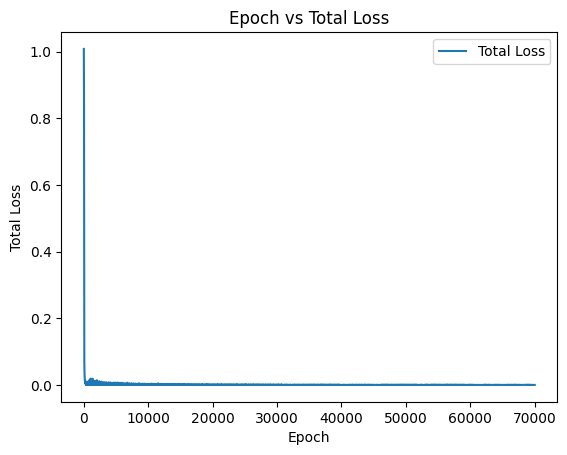

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

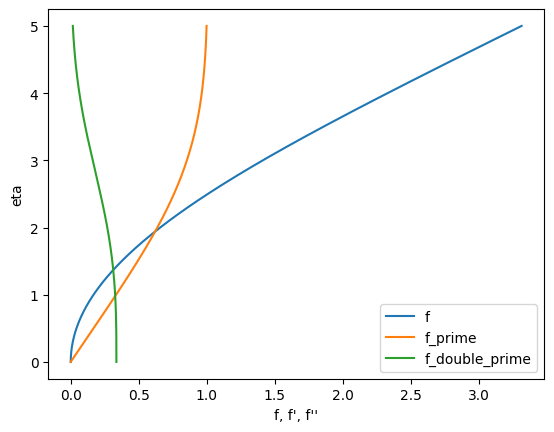

In [ ]:
f, f_prime, f_double_prime, _ = pinn(x_train1)
plt.plot(f.detach().numpy(), x_train1.detach().numpy(), label="f")
plt.plot(f_prime.detach().numpy(), x_train1.detach().numpy(), label="f_prime")
plt.plot(f_double_prime.detach().numpy(), x_train1.detach().numpy(), label="f_double_prime")
plt.xlabel("f, f', f''")
plt.ylabel("eta")
plt.legend()
plt.show()

In [ ]:
## Defining the PDE
def equation_2(theta, theta_x, theta_xx, x, f, Pr):
    return Pr*theta_x*0.5*f + theta_xx

In [ ]:
def boundary_conditions_loss2(theta, x):
    # Boundary condition at eta=0:
    loss_bc_0 = torch.mean((theta[0])**2)
    # Boundary condition at eta=inf:
    loss_bc_inf = torch.mean((theta[-1] - 1)**2)
    return loss_bc_0 + loss_bc_inf

In [ ]:
## Initialization of PINN
torch.manual_seed(69)
pinn2 = PINN(1,40,1,10)
optimizer2 = torch.optim.Adam(pinn2.parameters(), lr=0.0001)
torch.autograd.set_detect_anomaly(True)

In [ ]:
0## Training Loop
epochs = 20000
loss_history = []
for epoch in range(epochs):

  optimizer2.zero_grad()

  theta, theta_prime, theta_double_prime, _ = pinn2(x_train1)
  pde_loss2 = equation_2(theta, theta_prime, theta_double_prime, x_train1, f, 0.7).pow(2).mean()

  boundary_condition_losss2 = boundary_conditions_loss2(theta, x_train1)

  total_loss2 = pde_loss2 + boundary_condition_losss2

  total_loss2.backward(retain_graph=True)
  optimizer2.step()
  loss_history.append(total_loss2.item())
  if epoch % 100 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss2.item()}, pde Loss: {pde_loss2.item()}, Boundary Loss: {boundary_condition_losss2.item()}")

Epoch 0/20000, Total Loss: 0.8382015824317932, pde Loss: 1.1174120118084829e-07, Boundary Loss: 0.8382014632225037
Epoch 100/20000, Total Loss: 0.3311954438686371, pde Loss: 0.0012501808814704418, Boundary Loss: 0.32994526624679565
Epoch 200/20000, Total Loss: 0.01646600291132927, pde Loss: 0.014981469139456749, Boundary Loss: 0.0014845335390418768
Epoch 300/20000, Total Loss: 0.0014233906986191869, pde Loss: 0.0014015012420713902, Boundary Loss: 2.1889431081945077e-05
Epoch 400/20000, Total Loss: 0.0006910249358043075, pde Loss: 0.0006902255117893219, Boundary Loss: 7.994141242306796e-07
Epoch 500/20000, Total Loss: 0.0005699406610801816, pde Loss: 0.0005695514264516532, Boundary Loss: 3.892445761266572e-07
Epoch 600/20000, Total Loss: 0.0004890461568720639, pde Loss: 0.0004888447583653033, Boundary Loss: 2.0141852985489095e-07
Epoch 700/20000, Total Loss: 0.000430412677815184, pde Loss: 0.00043028497020713985, Boundary Loss: 1.2770503587944404e-07
Epoch 800/20000, Total Loss: 0.00038

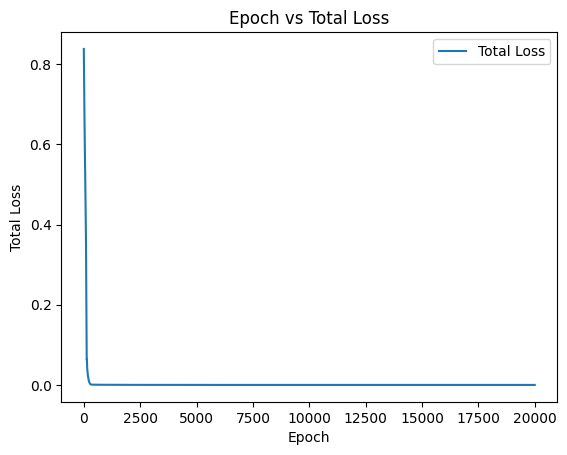

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

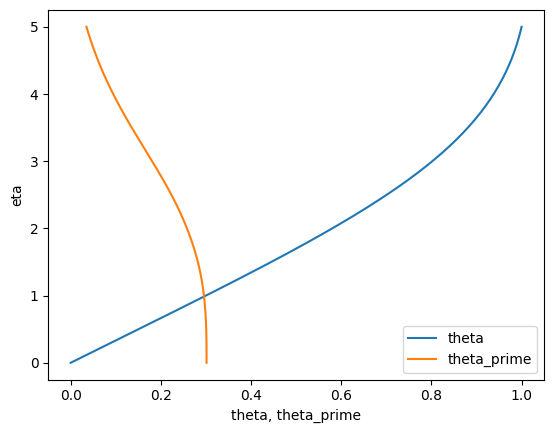

In [ ]:
theta, theta_prime, _, _= pinn2(x_train1)
plt.plot(theta.detach().numpy(), x_train1.detach().numpy(), label="theta")
plt.plot(theta_prime.detach().numpy(), x_train1.detach().numpy(), label="theta_prime")
plt.xlabel("theta, theta_prime")
plt.ylabel("eta")
plt.legend()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bl_convection.txt to bl_convection.txt


In [ ]:
file_path = '/content/bl_convection.txt'
delimiter = '    '
selected_columns = [0, 1, 2, 3, 4, 5]
selected_data = []

with open(file_path, 'r') as file:
    for line_number, line in enumerate(file, 1):
        columns = line.strip().split('    ')
        selected_values = [columns[i] for i in selected_columns]
        selected_data.append(selected_values)
column_names = ['eta', 'f', 'f_prime', 'f_double_prime', 'theta', 'theta_prime']
df_selected = pd.DataFrame(selected_data, columns=column_names)

df_copy  = df_selected
df_copy = df_copy.astype(str)

def apply(val):
  val_copy = val.split('D')
  return float(val_copy[0])*(10**(float(val_copy[1])))

df_copy = df_copy.applymap(apply)

column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
column_1_array = column_arrays[0]
column_2_array = column_arrays[1]
column_3_array = column_arrays[2]
column_4_array = column_arrays[3]
column_5_array = column_arrays[4]
column_6_array = column_arrays[5]
column_1_array = column_1_array[:300000:30000]
column_2_array = column_2_array[:300000:30000]
column_3_array = column_3_array[:300000:30000]
column_4_array = column_4_array[:300000:30000]
column_5_array = column_5_array[:300000:30000]
column_6_array = column_6_array[:300000:30000]
eta_plot = torch.tensor(column_1_array, dtype=torch.float32).reshape(10,1)
f_plot = torch.tensor(column_2_array, dtype=torch.float32).reshape(10,1)
f_prime_plot = torch.tensor(column_3_array, dtype=torch.float32).reshape(10,1)
f_double_prime_plot = torch.tensor(column_4_array, dtype=torch.float32).reshape(10,1)
theta_plot = torch.tensor(column_5_array, dtype=torch.float32).reshape(10,1)
theta_prime_plot = torch.tensor(column_6_array, dtype=torch.float32).reshape(10,1)

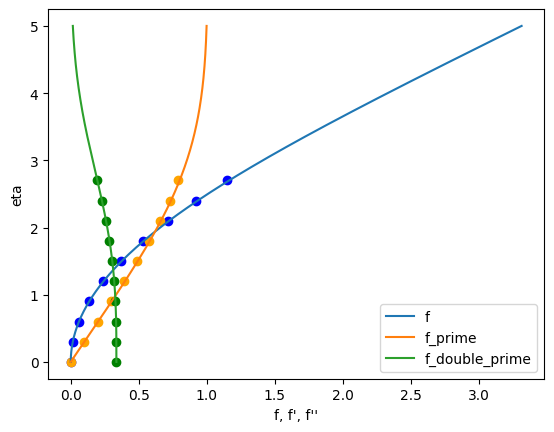

In [ ]:
plt.plot(f.detach().numpy(), x_train1.detach().numpy(), label="f")
plt.plot(f_prime.detach().numpy(), x_train1.detach().numpy(), label="f_prime")
plt.plot(f_double_prime.detach().numpy(), x_train1.detach().numpy(), label="f_double_prime")
plt.scatter(f_plot, eta_plot, color='blue', marker='o')
plt.scatter(f_prime_plot, eta_plot, color='orange', marker='o')
plt.scatter(f_double_prime_plot, eta_plot, color='green', marker='o')
plt.xlabel("f, f', f''")
plt.ylabel("eta")
plt.legend()
plt.show()

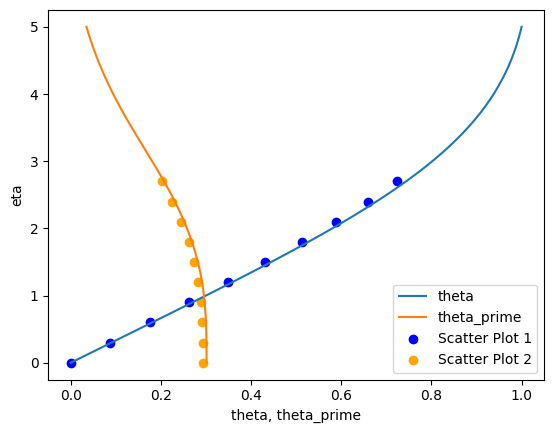

In [ ]:
plt.plot(theta.detach().numpy(), x_train1.detach().numpy(), label="theta")
plt.plot(theta_prime.detach().numpy(), x_train1.detach().numpy(), label="theta_prime")
plt.scatter(theta_plot, eta_plot, label='Scatter Plot 1', color='blue', marker='o')
plt.scatter(theta_prime_plot, eta_plot, label='Scatter Plot 2', color='orange', marker='o')
plt.xlabel("theta, theta_prime")
plt.ylabel("eta")
plt.legend()
plt.show()